In [22]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from sklearn import metrics
import gensim 
import numpy as np

### Extract Features and GOLD labels

In [2]:
# Load preprocessed training set & development set & test set
Linear_model =  LinearSVC(max_iter=10000)
Logreg_model = LogisticRegression(max_iter=10000)
Nb_model = MultinomialNB()
vectorizer = DictVectorizer()
train_set = pd.read_csv('data/preprocessed_train_set.conll', sep='\t')
dev_set = pd.read_csv('data/preprocessed_dev_set.conll', sep='\t')
test_set = pd.read_csv('data/preprocessed_test_set.conll', sep='\t')

In [3]:
def prepare_data(data_set):
    ## read data from conll files as panda dataframe##
    ## fill "0" to all instances with NAN value and extract all selected features and gold labels##
    features = data_set[["Token", "POS", "Chunk", "Cap", "Digit","Preceding_Token", "Proceeding_Token"]].fillna(0)
    gold_labels = data_set['GOLD'].values
    feature_dict = features.to_dict(orient='records')
    return feature_dict, gold_labels

def vectorize_data(features):
    ## use vetorized representation for train features  ##
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(features)
    return vec, features_vectorized

def train_model(model, features_vectorized, gold_labels):
    ## fit machine learning models on train features  ##
    model.fit(features_vectorized, gold_labels)
    return model

def predict(vec, model, data):
    
    ## train classifier to predict labels on dev data and generate classification report ##
    feature_dict, gold_labels = prepare_data(data)
    feature_vectorized = vec.transform(feature_dict) 
    
    predictions = model.predict(feature_vectorized)
    results = list()
    precision = metrics.precision_score(y_true=gold_labels, y_pred=predictions, average='macro', zero_division=0)
    recall = metrics.recall_score(y_true=gold_labels, y_pred=predictions, average='macro', zero_division=0)
    report = classification_report(gold_labels, predictions, zero_division=0)
    f1_score = metrics.f1_score(y_true=gold_labels, y_pred=predictions, average='macro', zero_division=0)
    subset = [round(precision, 3), round(recall, 3), round(f1_score, 3)]

    results.append(subset)
    print(results)
    print (report)
    

### Train different Learning Algorithms and Evaluate on Dev

Logistic Regression

In [4]:
train_feature_dict, train_gold_labels = prepare_data(train_set)
vec, train_features_vectorized = vectorize_data(train_feature_dict)
model = train_model(Logreg_model, train_features_vectorized, train_gold_labels)
predict(vec, model, dev_set)

[[0.882, 0.792, 0.83]]
              precision    recall  f1-score   support

       B-LOC       0.88      0.83      0.86      1837
      B-MISC       0.92      0.73      0.82       922
       B-ORG       0.82      0.73      0.78      1341
       B-PER       0.86      0.88      0.87      1842
       I-LOC       0.91      0.72      0.80       257
      I-MISC       0.91      0.61      0.73       346
       I-ORG       0.82      0.69      0.75       751
       I-PER       0.82      0.94      0.88      1303
           O       0.98      1.00      0.99     42120

    accuracy                           0.96     50719
   macro avg       0.88      0.79      0.83     50719
weighted avg       0.96      0.96      0.96     50719



Support Vector Machines (SVM)

In [5]:
train_feature_dict, train_gold_labels = prepare_data(train_set)
vec, train_features_vectorized = vectorize_data(train_feature_dict)
model = train_model(Linear_model, train_features_vectorized, train_gold_labels)
predict(vec, model, dev_set)

[[0.889, 0.836, 0.86]]
              precision    recall  f1-score   support

       B-LOC       0.91      0.86      0.89      1837
      B-MISC       0.92      0.80      0.86       922
       B-ORG       0.84      0.79      0.82      1341
       B-PER       0.90      0.90      0.90      1842
       I-LOC       0.89      0.81      0.85       257
      I-MISC       0.84      0.66      0.74       346
       I-ORG       0.84      0.74      0.79       751
       I-PER       0.87      0.95      0.91      1303
           O       0.99      1.00      0.99     42120

    accuracy                           0.97     50719
   macro avg       0.89      0.84      0.86     50719
weighted avg       0.97      0.97      0.97     50719



Multinomial Naive Bayes

In [6]:
train_feature_dict, train_gold_labels = prepare_data(train_set)
vec, train_features_vectorized = vectorize_data(train_feature_dict)
model = train_model(Nb_model, train_features_vectorized, train_gold_labels)
predict(vec, model, dev_set)

[[0.87, 0.627, 0.695]]
              precision    recall  f1-score   support

       B-LOC       0.72      0.87      0.79      1837
      B-MISC       0.90      0.60      0.72       922
       B-ORG       0.77      0.61      0.68      1341
       B-PER       0.95      0.71      0.81      1842
       I-LOC       0.88      0.23      0.36       257
      I-MISC       1.00      0.27      0.42       346
       I-ORG       0.76      0.57      0.65       751
       I-PER       0.90      0.81      0.85      1303
           O       0.96      0.99      0.98     42120

    accuracy                           0.94     50719
   macro avg       0.87      0.63      0.70     50719
weighted avg       0.94      0.94      0.94     50719



### Finetune the best model (SVM) on Dev data with GridSearch on Hyperparameter C

In [7]:
train_features = train_set.drop(["Token", "POS", "Chunk", "Cap", 
                             "Digit","Preceding_Token", "Proceeding_Token"], axis=1)
dev_features = dev_set.drop(["Token", "POS", "Chunk", "Cap", 
                             "Digit","Preceding_Token", "Proceeding_Token"], axis=1)
train_labels = train_set["GOLD"].copy()
dev_labels = dev_set["GOLD"].copy()
vec.fit_transform(train_features.to_dict(orient='records'))
dev_features_vectorized = vec.transform(dev_features.to_dict(orient='records'))

param_grid = {'C': [0.1, 1, 10, 100, 1000]} 
SVM = GridSearchCV(LinearSVC(max_iter=3300), 
                   param_grid, refit = True, verbose = 3, 
                   cv= 5, return_train_score=True)
SVM.fit(dev_features_vectorized, dev_labels)
print('Best Parameters : ', SVM.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .........C=0.1;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 2/5] END .........C=0.1;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 3/5] END .........C=0.1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END .........C=0.1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 5/5] END .........C=0.1;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END ...........C=1;, score=(train=1.000, test=1.000) total time=   0.3s
[CV 2/5] END ...........C=1;, score=(train=1.000, test=1.000) total time=   0.3s
[CV 3/5] END ...........C=1;, score=(train=1.000, test=1.000) total time=   0.3s
[CV 4/5] END ...........C=1;, score=(train=1.000, test=1.000) total time=   0.3s
[CV 5/5] END ...........C=1;, score=(train=1.000, test=1.000) total time=   0.3s
[CV 1/5] END ..........C=10;, score=(train=1.000, test=1.000) total time=   2.1s
[CV 2/5] END ..........C=10;, score=(train=1.000,

D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/5] END ........C=1000;, score=(train=1.000, test=1.000) total time=  34.3s


D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/5] END ........C=1000;, score=(train=1.000, test=1.000) total time=  33.7s


D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/5] END ........C=1000;, score=(train=1.000, test=1.000) total time=  33.1s


D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 4/5] END ........C=1000;, score=(train=1.000, test=1.000) total time=  34.2s


D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 5/5] END ........C=1000;, score=(train=1.000, test=1.000) total time=  33.1s
Best Parameters :  {'C': 0.1}


### Train best Hyperparametered SVM on train data

In [8]:
svm_classifier = LinearSVC(C=0.1)
svm_classifier.fit(train_features_vectorized, train_gold_labels)

LinearSVC(C=0.1)

### Evaluate best Hyperparametered SVM on dev data

In [9]:
dev_feature_dict, dev_gold_labels = prepare_data(dev_set)
vec, dev_features_vectorized = vectorize_data(dev_feature_dict)
model = train_model(svm_classifier, dev_features_vectorized, dev_gold_labels)
predict(vec, model, dev_set)

[[0.968, 0.893, 0.927]]
              precision    recall  f1-score   support

       B-LOC       0.94      0.95      0.95      1837
      B-MISC       0.96      0.83      0.89       922
       B-ORG       0.98      0.89      0.93      1341
       B-PER       0.96      0.95      0.95      1842
       I-LOC       0.97      0.87      0.92       257
      I-MISC       0.97      0.78      0.86       346
       I-ORG       0.97      0.79      0.87       751
       I-PER       0.96      0.98      0.97      1303
           O       0.99      1.00      0.99     42120

    accuracy                           0.98     50719
   macro avg       0.97      0.89      0.93     50719
weighted avg       0.98      0.98      0.98     50719



### Feature Ablation: find the least useful feature and remove it from set

In [10]:
def feature_ablation(features):
    results = []
    for feature in features:
        selected_features = ['Token', feature]
        train_features = train_set[selected_features]
        train_features_vectorized = vectorizer.fit_transform(train_features.to_dict('records'))
                
        # Train the SVM model with the best Hyperparameter C on training data
        svm_classifier = LinearSVC(C=0.1)
        svm_classifier.fit(train_features_vectorized, train_gold_labels)
                
        # Select subset of features in development set
        dev_features = dev_set[selected_features]
        dev_features_vectorized = vectorizer.transform(dev_features.to_dict('records'))
                
        # Evaluate the SVM model with selected features on development data
        predictions = svm_classifier.predict(dev_features_vectorized)
        precision = metrics.precision_score(y_true=dev_gold_labels, y_pred=predictions, average='macro', zero_division=0)
        recall = metrics.recall_score(y_true=dev_gold_labels, y_pred=predictions, average='macro', zero_division=0)
        f1_score = metrics.f1_score(y_true=dev_gold_labels, y_pred=predictions, average='macro', zero_division=0)
                
        # Add evaluation results to the dictionary
        features = ', '.join(selected_features)
        subset = [features, round(precision, 3), round(recall, 3), round(f1_score, 3)]
        results.append(subset)
    return results

In [11]:
features = ["POS", "Chunk", "Cap", "Digit","Preceding_Token", "Proceeding_Token"]
results = feature_ablation(features)
df = pd.DataFrame(results, columns = ['Feature subset', 'Precision', 'Recall', 'F1-score'])
df.sort_values('F1-score', ascending=False)

,Feature subset,Precision,Recall,F1-score
4,"Token, Preceding_Token",0.899,0.662,0.754
5,"Token, Proceeding_Token",0.853,0.617,0.709
0,"Token, POS",0.770,0.659,0.695
1,"Token, Chunk",0.834,0.563,0.654
3,"Token, Digit",0.811,0.553,0.641
2,"Token, Cap",0.811,0.552,0.637


### Drop the features that contributes least (Digit)

In [12]:
# Extract the bestset of features from all data
# selected_features = ["Token", "POS", "Chunk", "Cap","Preceding_Token"]
# train_features,dev_features, test_features = train_set[selected_features], dev_set[selected_features], test_set[selected_features]
# train_features_vectorized = vectorizer.fit_transform(train_features.to_dict('records'))
# dev_features_vectorized = vectorizer.transform(dev_features.to_dict('records'))
# test_features_vectorized = vectorizer.transform(test_features.to_dict('records'))
  
train_features = train_set[["Token", "POS", "Chunk", "Cap","Preceding_Token", "Proceeding_Token"]].fillna(0)
train_features_vectorized = vectorizer.fit_transform(train_features.to_dict('records'))
dev_features = dev_set[["Token", "POS", "Chunk", "Cap","Preceding_Token", "Proceeding_Token"]].fillna(0)
dev_features_vectorized = vectorizer.transform(dev_features.to_dict('records'))
test_features = test_set[["Token", "POS", "Chunk", "Cap","Preceding_Token", "Proceeding_Token"]].fillna(0)
test_features_vectorized = vectorizer.transform(test_features.to_dict('records'))
train_gold_labels = train_set['GOLD']
dev_gold_labels = dev_set['GOLD']
test_gold_labels = test_set['GOLD']

### Evaluate the SVM model with the best features set on Dev data

In [13]:
# Train the SVM model with the best Hyperparameter C on train data
svm_classifier = LinearSVC(C=0.1)
svm_classifier.fit(train_features_vectorized, train_gold_labels)

LinearSVC(C=0.1)

In [14]:
# Evaluate the SVM model on dev data
predictions = svm_classifier.predict(dev_features_vectorized)
report = classification_report(dev_gold_labels, predictions, digits=3)
results = list()
precision = metrics.precision_score(y_true=dev_gold_labels, y_pred=predictions, average='macro', zero_division=0)
recall = metrics.recall_score(y_true=dev_gold_labels, y_pred=predictions, average='macro', zero_division=0)
report = classification_report(dev_gold_labels, predictions, zero_division=0)
f1_score = metrics.f1_score(y_true=dev_gold_labels, y_pred=predictions, average='macro', zero_division=0)
subset = [round(precision, 3), round(recall, 3), round(f1_score, 3)]

results.append(subset)
print(results)
print(report)

[[0.883, 0.799, 0.834]]
              precision    recall  f1-score   support

       B-LOC       0.88      0.85      0.87      1837
      B-MISC       0.91      0.75      0.82       922
       B-ORG       0.84      0.74      0.79      1341
       B-PER       0.88      0.88      0.88      1842
       I-LOC       0.90      0.73      0.80       257
      I-MISC       0.88      0.61      0.72       346
       I-ORG       0.86      0.68      0.76       751
       I-PER       0.82      0.95      0.88      1303
           O       0.98      0.99      0.99     42120

    accuracy                           0.96     50719
   macro avg       0.88      0.80      0.83     50719
weighted avg       0.96      0.96      0.96     50719



### Evaluate the SVM model with the best features set on Test data

In [15]:
# Train the SVM model with the best Hyperparameter C on train data
svm_classifier = LinearSVC(C=0.1)
svm_classifier.fit(train_features_vectorized, train_gold_labels)

LinearSVC(C=0.1)

In [16]:
# Evaluate the SVM model on test data
test_gold_labels = test_set['GOLD'].values
predictions = svm_classifier.predict(test_features_vectorized)
report = classification_report(test_gold_labels, predictions, digits=3)
results = list()
precision = metrics.precision_score(y_true=test_gold_labels, y_pred=predictions, average='macro', zero_division=0)
recall = metrics.recall_score(y_true=test_gold_labels, y_pred=predictions, average='macro', zero_division=0)
report = classification_report(test_gold_labels, predictions, zero_division=0)
f1_score = metrics.f1_score(y_true=test_gold_labels, y_pred=predictions, average='macro', zero_division=0)
subset = [round(precision, 3), round(recall, 3), round(f1_score, 3)]

results.append(subset)
print(results)
print(report)

[[0.795, 0.748, 0.767]]
              precision    recall  f1-score   support

       B-LOC       0.83      0.79      0.81      1668
      B-MISC       0.80      0.64      0.71       702
       B-ORG       0.77      0.68      0.72      1661
       B-PER       0.79      0.81      0.80      1617
       I-LOC       0.78      0.65      0.71       257
      I-MISC       0.66      0.60      0.63       216
       I-ORG       0.80      0.62      0.70       835
       I-PER       0.75      0.95      0.84      1156
           O       0.98      0.99      0.98     37902

    accuracy                           0.95     46014
   macro avg       0.80      0.75      0.77     46014
weighted avg       0.95      0.95      0.95     46014



In [25]:
print('CONFUSION MATRIX')
cf_matrix = confusion_matrix(test_gold_labels, predictions)
print(cf_matrix)

CONFUSION MATRIX
[[ 1319    26   140    48     3     2     5    28    97]
 [   17   452    47    34     0     5     5    13   129]
 [  129    34  1126   126     1     6    28    32   179]
 [   53     2    53  1305     0     0     5    83   116]
 [    7     1     0     0   167     5    21    25    31]
 [    2    11     0     2     2   129    10    16    44]
 [   22     9    24     5    34     6   521    85   129]
 [    2     1     3    10     2     0    17  1099    22]
 [   31    27    78   117     6    42    43    86 37472]]


In [17]:
## CONFUSION MATRIX
label = ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']
from sklearn.metrics import ConfusionMatrixDisplay

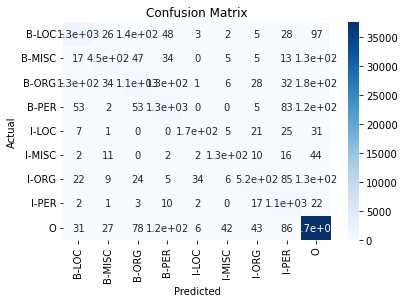

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# calculate confusion matrix
cm = confusion_matrix(test_gold_labels, predictions, labels=label)

# plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Error Analysis

Print all unmatched instances of the SVM model on test data

In [19]:
test_set['Predictions'] = predictions
mismatch_rows = test_set.loc[test_set['Predictions'] != test_set['GOLD']]
mismatch_rows[["Token", "POS", "Chunk", "Cap","Preceding_Token", "GOLD", "Predictions"]]

,Token,POS,Chunk,Cap,Preceding_Token,GOLD,Predictions
2,JAPAN,NNP,B-NP,True,-,B-LOC,B-ORG
4,LUCKY,NNP,B-NP,True,GET,O,B-ORG
7,CHINA,NNP,B-NP,True,",",B-PER,O
68,Uzbekistan,NNP,I-NP,False,newcomers,B-LOC,I-PER
86,Uzbek,NNP,B-NP,False,when,B-MISC,B-ORG
...,...,...,...,...,...,...,...
45837,Republic,NNP,I-NP,False,the,B-LOC,I-LOC
45838,of,IN,B-PP,False,Republic,I-LOC,O
45839,Ireland,NNP,B-NP,False,of,I-LOC,B-LOC
46002,1966,CD,I-NP,False,the,B-MISC,O


In [20]:
# word_embedding_model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin.gz', binary=True)  